In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

'/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'

In [2]:
def fun_similar_ratio(data, threshold_simu):
    return np.float(np.count_nonzero(data>threshold_simu))/len(data)

In [4]:
def fun_max_similarity_with_plot(positive_data, negative_data, plotFig=False):
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))

    tempDifference = np.array(tempPosCum) - np.array(tempNegCum)
    tempMax = np.max(tempDifference)
    tempPos = tempRanges[tempDifference==tempMax]
    if plotFig:
        plt.figure()
        plt.plot(tempRanges, tempPosCum, label='Positive')
        plt.plot(tempRanges, tempNegCum, label='Negative')
        plt.plot(tempRanges, tempDifference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(tempMax,tempPos))
        plt.grid()
        plt.legend()
    return tempPos, tempMax

def fun_ROC(positive_data, negative_data):
    """ Input: positive_data, negative_data are 1D numpy.array
    Output: simMax, maxDiff, ranges, posCum, negCum"""
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))
    return tempRanges, tempPosCum, tempNegCum

def fun_find_max(x,y, mode='returnAll'):
    x = np.array(x)
    y = np.array(y)
    maxY = np.max(y)
    maxX = x[y == maxY]
    if mode == 'returnAll':
        return maxX, maxY
    elif mode == 'returnFirst':
        if type(maxX) == np.ndarray:
            return maxX[0], maxY

def fun_find_max_similarity_difference(data_range, posCum, negCum):
    difference = np.array(posCum) - np.array(negCum)
    threshold_sim, maxSimDiff = fun_find_max(data_range, difference)
    return threshold_sim, maxSimDiff
    


def fun_max_similarity_v2(positive_data, negative_data, plotFig=False):
    numBins = 20;
    posCum_count = scipy.stats.cumfreq(positive_data, numbins=numBins,defaultreallimits=(0,1))
    posCum = posCum_count.cumcount / posCum_count.cumcount[-1]
    negCum_count = scipy.stats.cumfreq(negative_data, numbins=numBins,defaultreallimits=(0,1))
    negCum = negCum_count.cumcount / negCum_count.cumcount[-1]
    scan_range = np.arange(0,1, 1.0/numBins)
    difference = posCum - negCum
    maxSimDiff = np.max(difference)
    pos = scan_range[difference==maxSimDiff]
 
    if plotFig:
        plt.figure()
        plt.plot(scan_range, posCum, label='Positive')
        plt.plot(scan_range, negCum, label='Negative')
        plt.plot(scan_range, difference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(maxSimDiff,pos))
        plt.grid()
        plt.legend()
    return pos, maxSimDiff

### Load data

In [5]:
stack = 'MD589'
dataFolderName = 'NoCoords'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [6]:
section_valid_list = fun_get_valid_section_list(stack)
section_load_list = list(section_valid_list)

# Load saved blob features of {typical_blob, matched_pair, false_typical, false_matched_pairs}
typical_blob_props = collections.defaultdict(dict)
matched_blob_props = collections.defaultdict(dict)
false_typical_blob_props = collections.defaultdict(dict)
false_matched_blob_props = collections.defaultdict(dict)
for tempProp in scan_parameters['prop_to_save']:
    for tempSec in section_valid_list:
        try:
            typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='typical')
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_typical')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
            
for tempSec in section_valid_list:
    typical_blob_props[tempSec]['numBlobs'] = len(typical_blob_props[tempSec]['area'])
    false_typical_blob_props[tempSec]['numBlobs'] = len(false_typical_blob_props[tempSec]['area'])
# Load matching infomation            
for tempProp in ['section', 'TBID']:
    for tempSec in section_valid_list:
        try:
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
# Get relation between TBID and matched blob idx
TBID_to_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(typical_blob_props[tempSec]['numBlobs']):
        TBID_to_matched_blob[tempSec][tempBID] = np.where(matched_blob_props[tempSec]['TBID']==tempBID)[0]

# Get map between False typical blob ID and false_matched blobs idx
FTBID_to_false_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(false_typical_blob_props[tempSec]['numBlobs']):
        FTBID_to_false_matched_blob[tempSec][tempBID] = np.where(false_matched_blob_props[tempSec]['TBID']==tempBID)[0]

In [7]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [8]:
TBID_in_structure = collections.defaultdict(dict)
FTBID_in_structure = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        TBID_in_structure[tempSec][structure_name] =  np.where(fun_blobs_in_polygen(typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]
        FTBID_in_structure[tempSec][structure_name] = np.where(fun_blobs_in_polygen(false_typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]

# Training set of 7N

In [9]:
scan_parameters['training_props'] = training_props = ['area', 'eccentricity', 'compactness','moments_hu']

In [10]:
structure_name = '7N'

### Positive

In [11]:
nested_dict = lambda: defaultdict(nested_dict)
positive_similarity_sec_prop = collections.defaultdict(nested_dict)

for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        for tempProp in training_props:
            temp_sec_prop_similarity = []
            for tempBID in TBID_in_structure[tempSec][structure_name]:
                temp = fun_similarity(typical_blob_props[tempSec][tempProp][tempBID], 
                                                      matched_blob_props[tempSec][tempProp][TBID_to_matched_blob[tempSec][tempBID]],distance_type=tempProp)
                temp_sec_prop_similarity += temp
            positive_similarity_sec_prop[structure_name][tempSec][tempProp] = temp_sec_prop_similarity
        
positive_similarity_prop = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempProp in training_props:
        positive_similarity_prop[structure_name][tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in positive_similarity_sec_prop[structure_name].itervalues() if len(record[tempProp]) is not 0]))
positive_training_data = {}
for structure_name in set(contour_df['name']):
    temp_training_data = []
    for tempProp in training_props:
        temp_training_data.append(positive_similarity_prop[structure_name][tempProp])
    positive_training_data[structure_name] = np.column_stack(tuple(temp_training_data))

### Negative

In [12]:
negative_similarity_sec_prop = collections.defaultdict(nested_dict)

for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        for tempProp in training_props:
            temp_sec_prop_similarity = []
            for tempBID in FTBID_in_structure[tempSec][structure_name]:
                temp = fun_similarity(false_typical_blob_props[tempSec][tempProp][tempBID], 
                                                      false_matched_blob_props[tempSec][tempProp][FTBID_to_false_matched_blob[tempSec][tempBID]],distance_type=tempProp)
                temp_sec_prop_similarity += temp
            negative_similarity_sec_prop[structure_name][tempSec][tempProp] = temp_sec_prop_similarity

negative_similarity_prop = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempProp in training_props:
        negative_similarity_prop[structure_name][tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in negative_similarity_sec_prop[structure_name].itervalues() if len(record[tempProp]) is not 0]))
negative_training_data = {}
for structure_name in set(contour_df['name']):
    temp_training_data = []
    for tempProp in training_props:
        temp_training_data.append(negative_similarity_prop[structure_name][tempProp])
    negative_training_data[structure_name] = np.column_stack(tuple(temp_training_data))

            


# Tune the weights

Tune weight, try to seperate two distribution

In [281]:
maxSimDiff_scan = []
threshold_s_scan = []
tempWeightScan_range = range(0,200)
for tempWeight1 in tempWeightScan_range:
    weight = np.array([[100,70,tempWeight1]], dtype=np.float).T
    weight = weight / np.sum(weight)
    positive_weighted_similarity = np.dot(positive_training_data, weight)
    negative_weighted_similarity = np.dot(negative_training_data, weight)
    threshold_s, maxSimDiff = fun_max_similarity(positive_weighted_similarity, negative_weighted_similarity, plotFig=False)
    maxSimDiff_scan.append(maxSimDiff)
    threshold_s_scan.append(threshold_s)

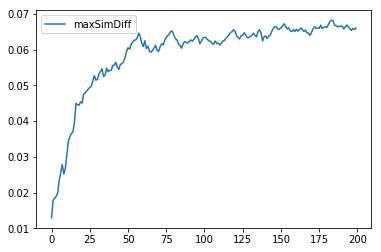

In [282]:
plt.plot(tempWeightScan_range, maxSimDiff_scan,label='maxSimDiff')
# plt.plot(tempWeightScan_range, threshold_s_scan,label='threshold_sim')
plt.legend()

### Stochastic gradient descent

In [26]:
structure_name = '7N'
positive_data = positive_training_data[structure_name]
negative_data = negative_training_data[structure_name]

In [13]:
def fun_ROC(positive_data, negative_data):
    """ Input: positive_data, negative_data are 1D numpy.array
    Output: ranges, posCum, negCum"""
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))
    return tempRanges, tempPosCum, tempNegCum

def fun_find_max(x,y, mode='returnAll'):
    x = np.array(x)
    y = np.array(y)
    maxY = np.max(y)
    maxX = x[y == maxY]
    if mode == 'returnAll':
        return maxX, maxY
    elif mode == 'returnFirst':
        if type(maxX) == np.ndarray:
            return maxX[0], maxY

def fun_find_max_similarity_difference(data_range, posCum, negCum):
    difference = np.array(posCum) - np.array(negCum)
    threshold_sim, maxSimDiff = fun_find_max(data_range, difference)
    return threshold_sim, maxSimDiff

def fun_SGD_score(weight, positive_training_data, negative_training_data):
    scan_range, posCum, negCum = fun_ROC(np.dot(positive_training_data, weight), np.dot(negative_training_data, weight) )
    _, maxSimDiff = fun_find_max_similarity_difference(scan_range, posCum, negCum)
    return maxSimDiff

In [116]:
learning_rate = 0.05;
sim_vector_length = 10
temp_matrix = np.eye(sim_vector_length, dtype=np.float)
learning_vectors = np.hstack(tuple([temp_matrix * learning_rate, temp_matrix * -learning_rate]))
learning_vectors = np.split(learning_vectors,sim_vector_length*2, axis=1)

In [130]:
# Initial similarity and weights:
numTrial = 1000
data_maxSimDiff = []
data_weight = []
for idx in range(numTrial):
    weight = np.random.random(size=[sim_vector_length, 1])
    weight = weight/np.sum(weight)
    scan_range, posCum, negCum = fun_ROC(np.dot(positive_data, weight), np.dot(negative_data, weight) )
    threshold_sim, maxSimDiff = fun_find_max_similarity_difference(scan_range, posCum, negCum)
    optimized_maxSimDiff, optimized_weight = fun_gradient_descent(learning_vectors=learning_vectors,
                                                                  initial_score=maxSimDiff, 
                                                                  initial_weight=weight , 
                                                                  positive_data=positive_data, 
                                                                  negative_data=negative_data)
    data_maxSimDiff.append(optimized_maxSimDiff)
    data_weight.append(optimized_weight)

In [ ]:
fun_find_max(x=data_)

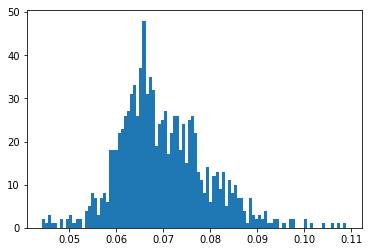

In [134]:
plt.hist(data_maxSimDiff, bins=100);

In [126]:
# Gradient descent: compute gradient
def fun_gradient_descent(learning_vectors, initial_score, initial_weight,positive_data, negative_data):
    tempMaxSimDiff = -1
#     numStep = 0
    while True:
        tempMaxSimDiffList = []
        tempWeightList = []
        for learning_vector in learning_vectors:
            # Update weight, with nonegative normalized constrains
            tempWeight = initial_weight.copy() + learning_vector
            tempWeight[tempWeight<0] = 0
            tempWeight = tempWeight/np.sum(tempWeight)
            tempWeightList.append(tempWeight)
            tempMaxSimDiffList.append(fun_SGD_score(tempWeight, positive_data, negative_data))
        tempWeight, tempMaxSimDiff = fun_find_max(x=tempWeightList, y=tempMaxSimDiffList,mode='returnFirst')
        if tempMaxSimDiff > initial_score:
#             numStep +=1
            initial_score = tempMaxSimDiff
            initial_weight = tempWeight
        else:
#             print('Reach Local maximum. Break.')
            break
    return initial_score, initial_weight
    


### Find good weight by stochastic initialization

In [ ]:
data_weight = []
data_maxSimDiff = []

In [61]:
# data_weight = list(data_weight)
# data_maxSimDiff = list(data_maxSimDiff)
numTry = 400
numTryPerTime = 5000
for tempTry in range(0, numTry):
    print(float(tempTry)/numTry)
    for temp in range(0,numTryPerTime):
        weight = np.random.random(size=[10,1])
        weight = weight / np.sum(weight)
        positive_weighted_similarity = np.dot(positive_training_data, weight)
        negative_weighted_similarity = np.dot(negative_training_data, weight)
        threshold_s, maxSimDiff = fun_max_similarity(positive_weighted_similarity, negative_weighted_similarity, plotFig=False)
        data_weight.append(weight.flatten())
        data_maxSimDiff.append(maxSimDiff)        

0.0
0.0025
0.005
0.0075
0.01
0.0125
0.015
0.0175
0.02
0.0225
0.025
0.0275
0.03
0.0325
0.035
0.0375
0.04
0.0425
0.045
0.0475
0.05
0.0525
0.055
0.0575
0.06
0.0625
0.065
0.0675
0.07
0.0725
0.075
0.0775
0.08
0.0825
0.085
0.0875
0.09
0.0925
0.095
0.0975
0.1
0.1025
0.105
0.1075
0.11
0.1125
0.115
0.1175
0.12
0.1225
0.125
0.1275
0.13
0.1325
0.135
0.1375
0.14
0.1425
0.145
0.1475
0.15
0.1525
0.155
0.1575
0.16
0.1625
0.165
0.1675
0.17
0.1725
0.175
0.1775
0.18
0.1825
0.185
0.1875
0.19
0.1925
0.195
0.1975
0.2
0.2025
0.205
0.2075
0.21
0.2125
0.215
0.2175
0.22
0.2225
0.225
0.2275
0.23
0.2325
0.235
0.2375
0.24
0.2425
0.245
0.2475
0.25
0.2525
0.255
0.2575
0.26
0.2625
0.265
0.2675
0.27
0.2725
0.275
0.2775
0.28
0.2825
0.285
0.2875
0.29
0.2925
0.295
0.2975
0.3
0.3025
0.305
0.3075
0.31
0.3125
0.315
0.3175
0.32
0.3225
0.325
0.3275
0.33
0.3325
0.335
0.3375
0.34
0.3425
0.345
0.3475
0.35
0.3525
0.355
0.3575
0.36
0.3625
0.365
0.3675
0.37
0.3725
0.375
0.3775
0.38
0.3825
0.385
0.3875
0.39
0.3925
0.395
0.3975
0.4


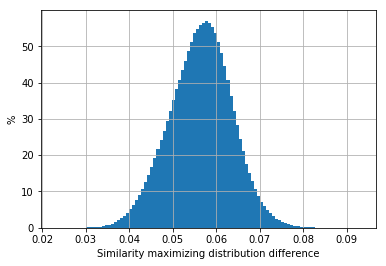

In [120]:
tempNumBin = 100
plt.hist(data_maxSimDiff, tempNumBin, normed=True);
plt.grid()
plt.xlabel('Similarity maximizing distribution difference')
plt.ylabel('%')
# plt.yscale('log')

In [182]:
import numba

In [121]:
fun_create_folder('/shared/blob_matching_atlas/training_weight/MD589/7N/stochastic_initialization')

Folder created: /shared/blob_matching_atlas/training_weight/MD589/7N/stochastic_initialization

In [122]:
bp.pack_ndarray_file(data_weight, filename='/shared/blob_matching_atlas/training_weight/MD589/7N/stochastic_initialization/weight.bp')
bp.pack_ndarray_file(data_maxSimDiff, filename='/shared/blob_matching_atlas/training_weight/MD589/7N/stochastic_initialization/maxSimDiff.bp')

In [100]:
data_weight = np.array(data_weight)
data_maxSimDiff = np.array(data_maxSimDiff)

In [101]:
tempGoodResult = data_weight[data_maxSimDiff > 0.09]
tempGoodResult

array([[ 0.10315924,  0.01021359,  0.18097468,  0.39090934,  0.05026666,
         0.17715124,  0.00091428,  0.02301327,  0.03374943,  0.02964826],
       [ 0.20574105,  0.02375814,  0.11356584,  0.38726311,  0.06430219,
         0.0552819 ,  0.02866969,  0.00077406,  0.04945738,  0.07118664]])

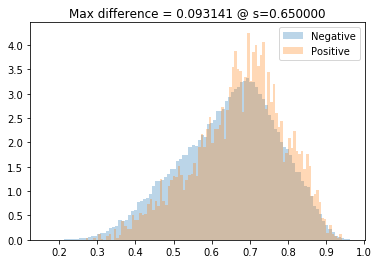

In [104]:
tempBinNum = 100
tempNormed = True
tempCumulated = False

# weight = np.array([[20,15,50]], dtype=np.float).T
# weight = weight / np.sum(weight)
weight = tempGoodResult[0,:]
positive_weighted_similarity = np.dot(positive_training_data, weight)
negative_weighted_similarity = np.dot(negative_training_data, weight)
threshold_s, maxSimDiff = fun_max_similarity(positive_weighted_similarity, negative_weighted_similarity, plotFig=False)
plt.figure()
plt.hist(negative_weighted_similarity,bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Negative');
plt.hist(positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Positive');
plt.title('Max difference = %f @ s=%f'%(maxSimDiff, threshold_s))
plt.legend()

In [108]:
goodweight08 = data_weight[data_maxSimDiff>0.08]
goodweight07 = data_weight[data_maxSimDiff>0.07]

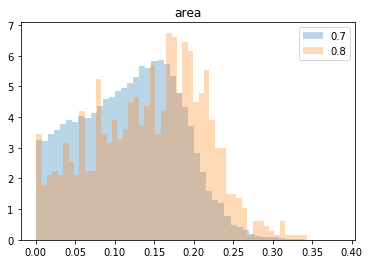

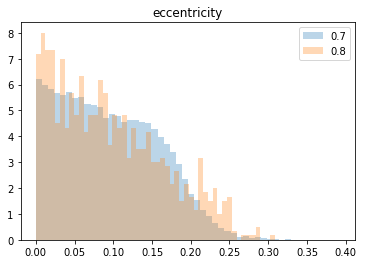

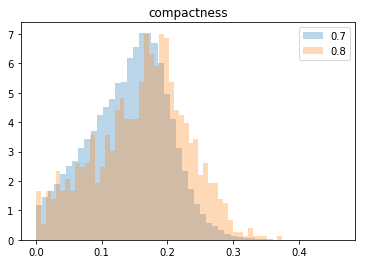

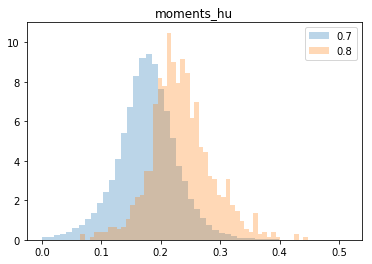

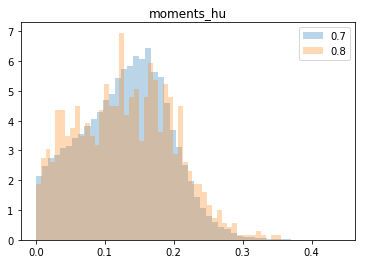

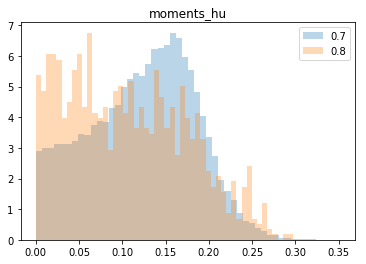

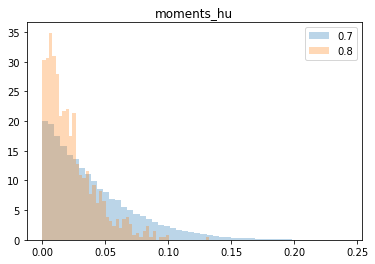

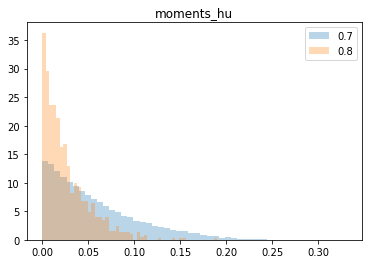

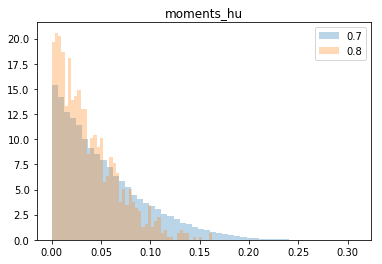

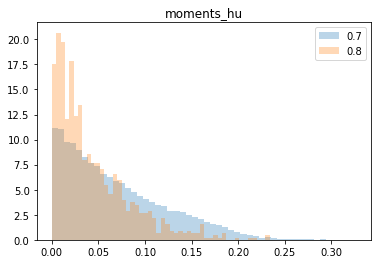

In [180]:
tempTitle = scan_parameters['training_props'] + ['moments_hu']*6
tempNormalized = True
for tempIdx in range(10):
    plt.figure()
    plt.hist(goodweight07[:, tempIdx], bins=50, normed=tempNormalized, alpha=0.3, label='0.7');
    plt.hist(goodweight08[:, tempIdx], bins=50, normed=tempNormalized, alpha=0.3, label='0.8');
    plt.title(tempTitle[tempIdx])
    plt.legend()

# Analysis

### Distribution differnece

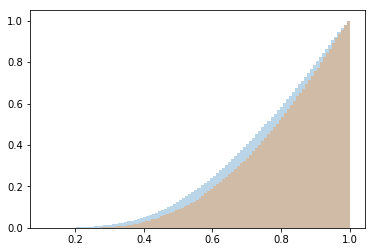

In [214]:
tempProp = 'compactness'
tempBinNum = 100
plt.hist(negative_similarity_prop[tempProp],bins=tempBinNum,normed=True, alpha=0.3,cumulative=True);
plt.hist(positive_similarity_prop[tempProp],bins=tempBinNum,normed=True,alpha=0.3,cumulative=True);

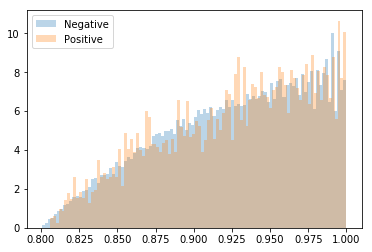

In [231]:
tempProp = 'area'
tempBinNum = 100
tempNormed = True
tempCumulated = False
plt.hist(negative_similarity_prop[tempProp],bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Negative');
plt.hist(positive_similarity_prop[tempProp],bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Positive');
plt.legend()